In [63]:
import sys
import time
import json
import pytz
import datetime
import warnings
import numpy as np
import talib as ta
import pandas as pd
import seaborn as sns
from tda import auth, client
import matplotlib.pyplot as plt

# ML libraries
from sklearn.svm import SVC
from scipy.stats import linregress
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# extentions
sys.path.append('C:/Users/ivanz/Documents/trading/algotrading_config')
from conf import api_key,redirect_uri,token_path,account_id,executable_path
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
def data_cleaning_engineering(df):
    """ Prepare data for modeling. Engineering Financial Indicators """
    # Drop the rows with zero volume traded
    df = df.drop(df[df['volume'] == 0].index)
    # Create a variable n with a value of 10
    n = 10
    # Create a column by name, RSI and assign the calculation of RSI to it
    df['RSI'] = ta.RSI(np.array(df['close'].shift(1)), timeperiod=n)
    
    # Create a column by name, SMA and assign the SMA calculation to it
    df['SMA'] = df['close'].shift(1).rolling(window=n).mean()
    # Create a column by name, Corr and assign the calculation of correlation to it
    df['Corr'] = df['close'].shift(1).rolling(window=n).corr(df['SMA'].shift(1))
    # Create a column by name, SAR and assign the SAR calculation to it
    df['SAR'] = ta.SAR(np.array(df['high'].shift(1)), np.array(df['low'].shift(1)), 0.2, 0.2)
    # Create a column by name, ADX and assign the ADX calculation to it
    df['ADX'] = ta.ADX(np.array(df['high'].shift(1)), np.array(df['low'].shift(1)),
                       np.array(df['open']), timeperiod=n)
    
    # Create columns high, low and close with previous minute's OHLC data
    df['Prev_High'] = df['high'].shift(1)
    df['Prev_Low'] = df['low'].shift(1)
    df['Prev_Close'] = df['close'].shift(1)

    # Create columns 'OO' with the difference between the current minute's open and last minute's open
    df['OO'] = df['open']-df['open'].shift(1)
    # Create columns 'OC' with the difference between the current minute's open and last minute's close
    df['OC'] = df['open']-df['Prev_Close']
    
    # (close-low)/(high-low)
    df['Normalized'] = (df['close']-df['low'])/(df['high']-df['low'])
    
    # calculate slope of regression for Close price of last 3,5,10,20 min
    for day,reg_period in zip([3,5,10,20], ['reg_3','reg_5', 'reg_10', 'reg_20']):
        df[reg_period] =  df['close'].rolling(window=day).apply(get_slope, raw=False)
        
    # Create a column 'Ret' with the calculation of returns
    df['Ret'] = (df['open'].shift(-1)-df['open'])/df['open']

    # Create n columns and assign
    for i in range(1, n):
        df['return%i' % i] = df['Ret'].shift(i)
    df.iloc[-1:] = df.iloc[-1:].fillna(0)
    
    # Additional Cleaning 
    # Change the value of 'Corr' to -1 if it is less than -1
    df.loc[df['Corr'] < -1, 'Corr'] = -1
    # Change the value of 'Corr' to 1 if it is greater than 1
    df.loc[df['Corr'] > 1, 'Corr'] = 1
    # Drop the NaN values
    df = df.dropna()
    
    # Create a column by name, 'Signal' and initialize with 0
    df['Signal'] = 0
    # Assign a value of 1 to 'Signal' column for the quantile with the highest returns
    df.loc[df['Ret'] > df['Ret'].quantile(q=0.66), 'Signal'] = 1
    # Assign a value of -1 to 'Signal' column for the quantile with the lowest returns
    df.loc[df['Ret'] < df['Ret'].quantile(q=0.34), 'Signal'] = -1
    
    return df

In [56]:
def train_classifier_predict(df):
    """ Training Model with Best Params and make prediction for the last min data """
    # Use drop method to drop the columns
    X = df.drop(['close', 'Signal', 'high', 'volume', 'low', 'Ret'], axis=1)
    # Create a variable which contains all the 'Signal' values
    y = df['Signal']
    
    # Create a variable split that stores 80% of the length of the dataframe
    t = .98
    split = int(t*len(df))
    
    # Test variables for 'c' and 'g'
    #Setting the different values to test within C, Gamma and Kernel
    c = [10, 100, 1000, 10000]
    g = [1e-2, 1e-1, 1e0]
    # Intialise the parameters
    parameters = {'svc__C': c,
                  'svc__gamma': g,
                  'svc__kernel': ['rbf']}
    #Creating the step by step pipeline
    # Create the 'steps' variable with the pipeline functions
    steps = [('scaler', StandardScaler()), ('svc', SVC())]
    # Pass the 'steps' to the Pipeline function
    pipeline = Pipeline(steps)
    #Creating a randomized function to help to find the best parameters.
    # Call the RandomizedSearchCV function and pass the parameters
    rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=10))
    
    # Call the 'fit' method of rcv and pass the train data to it
    rcv.fit(X.iloc[:split], y.iloc[:split])
    # Call the 'best_params_' method to obtain the best parameters of C
    best_C = rcv.best_params_['svc__C']
    # Call the 'best_params_' method to obtain the best parameters of kernel
    best_kernel = rcv.best_params_['svc__kernel']
    # Call the 'best_params_' method to obtain the best parameters of gamma
    best_gamma = rcv.best_params_['svc__gamma']
    
    # Create a new SVC classifier
    cls = SVC(C=best_C, kernel = best_kernel, gamma=best_gamma)
    # Instantiate the StandardScaler
    ss1 = StandardScaler()
    # Pass the scaled train data to the SVC classifier
    cls.fit(ss1.fit_transform(X.iloc[:split]), y.iloc[:split])
    
    y_predict = cls.predict(ss1.transform(X.iloc[split:]))
    cm = confusion_matrix(y.iloc[split:], y_predict)
    accuracy  = np.trace(cm) / float(np.sum(cm))
    
    prediction = cls.predict(ss1.transform(X.iloc[-1:]))
    timestamp = X.iloc[-1:].index
    return timestamp, int(prediction), X.iloc[-1:], accuracy

In [57]:
def get_slope(array):
    """ calculate a slope of line cross points in array with OLSR """
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

def get_account_acess(api_key, redirect_uri, token_path, account_id, executable_path):
    """ Creates a client with credantials which allows to make API calls """
    try:
        c = auth.client_from_token_file(token_path, api_key)
    except FileNotFoundError:
        from selenium import webdriver
        with webdriver.Chrome(executable_path = executable_path) as driver:
            c = auth.client_from_login_flow(
                driver, api_key, redirect_uri, token_path)
    return c

def keep_trade_history(current_time, quote, pred_signal, accuracy):
    
    # if no orders executed yet and pred signal 1 - add new signal order
    if len(d_current_trading_signal['Pred_sig']) == 0 and pred_signal==1:
        d_current_trading_signal['Pred_sig'][current_time] = pred_signal
        d_current_trading_signal['accuracy'][current_time] = accuracy
        d_current_trading_signal['quote'][current_time] = quote
    # if pred signal 1 but last filled order was 1 - pass
    elif pred_signal == 1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == 1:
        pass
    # if pred signal -1 and there is no previous signal - pass
    elif pred_signal == -1 and len(d_current_trading_signal['Pred_sig']) == 0:
        pass
    # if pred signal -1 but last filled order was -1 - pass
    elif pred_signal == -1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == -1:
        pass
    # if pred signal 1 but last filled order was -1 - add new signal order
    elif pred_signal == 1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == -1:
        d_current_trading_signal['Pred_sig'][current_time] = pred_signal
        d_current_trading_signal['accuracy'][current_time] = accuracy
        d_current_trading_signal['quote'][current_time] = quote
    # if pred signal -1 but last filled order was 1 - add new signal order
    elif pred_signal == -1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == 1:
        d_current_trading_signal['Pred_sig'][current_time] = pred_signal
        d_current_trading_signal['accuracy'][current_time] = accuracy
        d_current_trading_signal['quote'][current_time] = quote
    else: pass
    
def timer(new_minute = False, timezone = pytz.timezone('America/New_York')):
    """ Getting current time every 5s and checking if current time exist
        in time_list(by minutes). Once current time match any in time_list
        remove value from time_list and return True value
    """
    while new_minute==False:
        # get current minute
        current_time = datetime.datetime.strftime(datetime.datetime.now(tz = timezone), '%Y-%m-%d %H:%M')
        if  current_time in time_list: # if current time appears in time_list
            time_list.remove(current_time) # remove current time from time_list
            break # exit loop and return True
        time.sleep(5)
    return True

def results_to_dict(current_time, latest_minute_respond, quote, buy_power, pred_signal, accuracy):
    """ Saving results from API calls and modeling to dict """
    d_result_position_signal['respond_timestamp'][current_time] = latest_minute_respond
    d_result_position_signal['Pred_Signal'][current_time] = pred_signal
    d_result_position_signal['accuracy'][current_time] = accuracy
    d_result_position_signal['quote'][current_time] = quote
    d_result_position_signal['buy_power'][current_time] = buy_power
    return

def get_hist_data(connection, symbol, start_datetime):
    """API calls to get historical stock data by minute"""
    df = pd.DataFrame(connection.get_price_history_every_minute(symbol, 
                                                                start_datetime = datetime.datetime.fromisoformat('2022-04-14 09:30:00'),
                                                                need_extended_hours_data=False).json()['candles'])
    df['datetime'] = df['datetime'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000.0))
    df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d %H:%M:%S'))
    df = df.set_index('datetime')
    return df

def current_min_data(connection, symbol, current_time, start_datetime, latest_data_avail = False):
    """ API request for historycal data and checking if there is data about current minute """
    while latest_data_avail == False:
        # get historical data about EQUITY for modeling
        stock_hist_data = get_hist_data(connection, symbol, start_datetime)
        latest_minute_respond = stock_hist_data.iloc[-1:].index[0][:-3]
        if current_time == latest_minute_respond:
            break
        else:
            time.sleep(1)
    return latest_minute_respond, stock_hist_data 

def generate_datetimes(date_from_str, minutes_count):
    date_from = datetime.datetime.strptime(date_from_str, '%Y-%m-%d %H:%M:%S')
    for minute in range(minutes_count): #390 #interval minutes from starting time
        yield date_from + datetime.timedelta(minutes=minute)
        
def initialize_results_frame(date_from_str, minutes_count):
    """ Initialise frame for results 
        Args: 
            date_from_str(str)-starting day,time,min for timelist/'2022-04-13 09:30:00'/
            minutes_count(int)-number of minutes from date_from_str
        Rrt:
            time_list - with 1 min interval
            d_result_position_signal - dict with records from API calls
    """
    time_list=[date.strftime('%Y-%m-%d %H:%M') for date in generate_datetimes(date_from_str, minutes_count)]
    # dict with results from API calls and modeling
    d = {}; d['respond_timestamp']={}; d['quote']={}; d['Pred_Signal']={}; d['buy_power']={}; d['accuracy']={}
    # dict for tracking latest pred_signals
    d_hist_s = {}; d_hist_s['Pred_sig']={}; d_hist_s['accuracy']={}; d_hist_s['quote']={}
    return time_list, d, d_hist_s

In [58]:
def run(symbol='TSLA', start_datetime='2022-04-14 09:30:00'):
    """ * creates connection for API calls
        * gets historical data of symbol and quote
        * runs ML model 
        * gets account info
        * save results """
    if timer() == True:
        accuracy, latest_minute_respond = False, False
        # get current minute
        current_time = datetime.datetime.strftime(datetime.datetime.now(tz=pytz.timezone('America/New_York')), '%Y-%m-%d %H:%M')
        # authorize connection. create a client for API calls
        connection = get_account_acess(api_key, redirect_uri, token_path, account_id, executable_path)
        try:
            # get historical data about EQUITY for modeling up to current_minute
            latest_minute_respond, stock_hist_data = current_min_data(latest_data_avail=False, 
                                                                      start_datetime=start_datetime,
                                                                      current_time=current_time,
                                                                      connection=connection, 
                                                                      symbol=symbol)        
            # cleaning data and prepare for modeling                                                                 
            data_clean = data_cleaning_engineering(stock_hist_data)
            # run the model and make a prediction on a last input
            respond_timestamp, pred_signal, last_min_data, accuracy = train_classifier_predict(data_clean)
            # get current quote of the equity
            quote = connection.get_quote(symbol).json()[symbol]['askPrice']
            # get account information (avail funds for trade)
            buy_power = connection.get_account(account_id=account_id).json()['securitiesAccount']['currentBalances']['buyingPowerNonMarginableTrade']
            #saving results to the dict.
            results_to_dict(current_time, latest_minute_respond, quote, buy_power, pred_signal, round(accuracy,2))
            # filling with records about trades:
            keep_trade_history(current_time, quote, pred_signal, round(accuracy,2))
            hist_last_min_data.append(last_min_data)
        except:
            print(f"There is no API respond for {current_time}")
            
        if len(time_list)==0: return print('Time is over')
        elif accuracy and latest_minute_respond:
            print(f"Results for {latest_minute_respond} saved with classifier accuracy: {accuracy}") 
        else:
            print(f"There is no results for {current_time} and classifier accuracy: {None}") 
        run()
    return 

In [68]:
###### DECLARE GLOBAL VARIABLES #######0
time_list, d_result_position_signal, d_current_trading_signal = initialize_results_frame(date_from_str='2022-04-25 09:36:00', minutes_count=384)
hist_last_min_data = []

print(d_current_trading_signal)
print(d_result_position_signal)
print(time_list[-5:])

{'Pred_sig': {}, 'accuracy': {}, 'quote': {}}
{'respond_timestamp': {}, 'quote': {}, 'Pred_Signal': {}, 'buy_power': {}, 'accuracy': {}}
['2022-04-25 15:55', '2022-04-25 15:56', '2022-04-25 15:57', '2022-04-25 15:58', '2022-04-25 15:59']


In [69]:
run()

Results for 2022-04-25 09:36 saved with classifier accuracy: 0.8085106382978723
There is no API respond for 2022-04-25 09:37
There is no results for 2022-04-25 09:37 and classifier accuracy: None
Results for 2022-04-25 09:38 saved with classifier accuracy: 0.7872340425531915
Results for 2022-04-25 09:39 saved with classifier accuracy: 0.8085106382978723
Results for 2022-04-25 09:40 saved with classifier accuracy: 0.8085106382978723
Results for 2022-04-25 09:41 saved with classifier accuracy: 0.8297872340425532
Results for 2022-04-25 09:42 saved with classifier accuracy: 0.8297872340425532
Results for 2022-04-25 09:43 saved with classifier accuracy: 0.8085106382978723
Results for 2022-04-25 09:44 saved with classifier accuracy: 0.8085106382978723
Results for 2022-04-25 09:45 saved with classifier accuracy: 0.8297872340425532
Results for 2022-04-25 09:46 saved with classifier accuracy: 0.7659574468085106
Results for 2022-04-25 09:47 saved with classifier accuracy: 0.7659574468085106
Resu

In [70]:
df_current_trading_signal = pd.DataFrame(d_current_trading_signal)
df_result_position_signal = pd.DataFrame(d_result_position_signal)
df_hist_last_min_data = pd.concat(hist_last_min_data)

In [73]:
df_hist_last_min_data.head()

,open,RSI,SMA,Corr,SAR,ADX,Prev_High,Prev_Low,Prev_Close,OO,OC,Normalized,reg_3,reg_5,reg_10,reg_20,return1,return2,return3,return4,return5,return6,return7,return8,return9
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-25 09:36:00,981.7600,29.074948,990.68332,0.653771,987.665824,45.623483,986.57,980.9800,981.9000,0.7800,-0.1400,0.000000,-0.02005,-0.44043,-3.020804,-1.763583,0.000795,0.002468,-0.005149,0.001474,0.006231,-0.002932,-0.025900,-0.000661,-0.000552
2022-04-25 09:38:00,988.4249,41.907084,986.74932,0.364913,975.300000,44.961177,989.06,983.1600,988.3500,3.4849,0.0749,1.000000,2.67250,2.47698,-0.268275,-1.613878,0.003538,0.003239,0.000795,0.002468,-0.005149,0.001474,0.006231,-0.002932,-0.025900
2022-04-25 09:39:00,990.8950,46.586902,985.33182,0.011815,977.889700,42.701871,992.00,988.1674,991.0450,2.4701,-0.1500,0.000000,0.85635,2.28054,1.358894,-1.510112,0.002499,0.003538,0.003239,0.000795,0.002468,-0.005149,0.001474,0.006231,-0.002932
2022-04-25 09:40:00,985.5518,39.133038,983.36882,-0.772347,980.711760,41.814279,991.27,983.1600,985.3100,-5.3432,0.2418,0.784892,-2.23255,0.09898,0.797884,-1.514653,-0.005392,0.002499,0.003538,0.003239,0.000795,0.002468,-0.005149,0.001474,0.006231
2022-04-25 09:41:00,984.0300,38.300181,984.20817,-0.604178,982.969408,41.049940,987.45,983.0000,984.6085,-1.5218,-0.5785,0.000000,-0.65500,-1.51365,0.546454,-1.497792,-0.001544,-0.005392,0.002499,0.003538,0.003239,0.000795,0.002468,-0.005149,0.001474


In [82]:
df_current_trading_signal.to_csv('../results/df_current_trading_signal_4_25.csv')
df_result_position_signal.to_csv('../results/df_result_position_signal_4_25.csv')
df_hist_last_min_data.to_csv('../results/df_hist_last_min_data_4_25.csv')

### Analyze results

In [74]:
# calculate pct return at each switch signal
df_result_position_signal['Return'] = 100*df_result_position_signal['quote'].pct_change()
df_result_position_signal['Return'] = np.where(df_result_position_signal['Pred_Signal']==-1, df_result_position_signal['Return'], np.nan)
df_result_position_signal= df_result_position_signal.reset_index()
df_result_position_signal =  df_result_position_signal.rename(columns={'index':'datetime'})
df_result_position_signal['cum_sum_return'] = df_result_position_signal['Return'].cumsum()

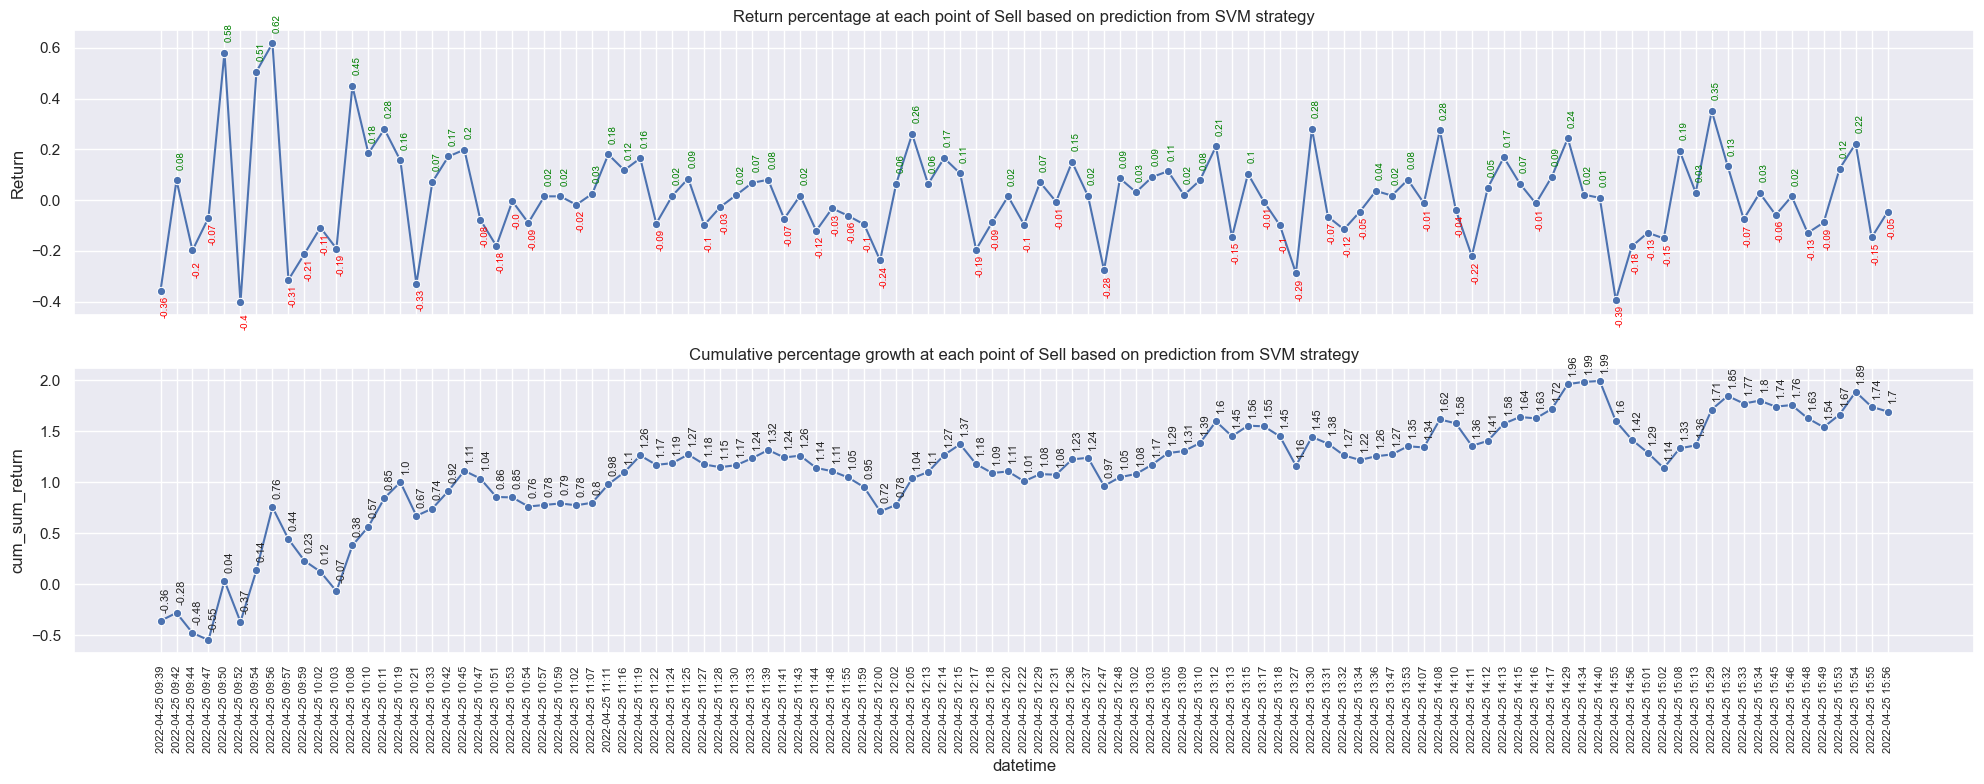

In [90]:
fig, ax = plt.subplots(2,1, figsize=(20,8))

ax[0].set_title('Return percentage at each point of Sell based on prediction from SVM strategy')
ax[0].set_ylabel('Return, pct')
plt.setp(ax[0].get_xticklabels(), visible=False)
sns.lineplot(x='datetime', y='Return', data=df_result_position_signal, marker='o', ax=ax[0])
for xx,yy,m in df_result_position_signal[['datetime','Return','Return']].dropna().values:
        if m<0: ax[0].text(xx,yy-0.1,round(m,2), size =7, rotation =90, color='red')
        else: ax[0].text(xx,yy+0.05,round(m,2), size =7, rotation =90, color='green')

ax[1].set_title('Cumulative percentage growth at each point of Sell based on prediction from SVM strategy')
plt.setp(ax[1].get_xticklabels(), rotation=90, size =8)
sns.lineplot(x='datetime', y='cum_sum_return', data=df_result_position_signal, marker='o', ax=ax[1])
for xx,yy,m in df_result_position_signal[['datetime','cum_sum_return','cum_sum_return']].dropna().values:
        ax[1].text(xx,yy+0.1,round(m,2), size =8, rotation =90)
plt.tight_layout()
plt.savefig('../results/cum_return_per_min_report.png')
plt.show()

In [92]:
df_result_position_signal.to_csv('../results/cum_return_per_min_report.csv')

In [96]:
df_current_trading_signal.reset_index()

,index,Pred_sig,accuracy,quote
0,2022-04-25 09:36,1,0.81,980.57
1,2022-04-25 09:39,-1,0.81,988.23
2,2022-04-25 09:40,1,0.81,985.77
3,2022-04-25 09:42,-1,0.83,984.76
4,2022-04-25 09:43,1,0.81,986.77
5,2022-04-25 09:44,-1,0.81,984.82
6,2022-04-25 09:46,1,0.77,980.80
7,2022-04-25 09:47,-1,0.77,980.12
8,2022-04-25 09:55,1,0.85,989.57
9,2022-04-25 09:56,-1,0.83,995.68
